First five rows:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1.0,0,1,29.85,29.85,0,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,0,34.0,1,0,56.95,1889.50,0,...,False,False,False,False,False,True,False,False,False,True
2,0,0,0,0,2.0,1,1,53.85,108.15,1,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0,0,45.0,0,0,42.30,1840.75,0,...,True,False,False,False,False,True,False,False,False,False
4,1,0,0,0,2.0,1,1,70.70,151.65,1,...,False,False,False,False,False,False,False,False,True,False



Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7032 non-null   int64  
 1   SeniorCitizen                          7032 non-null   int64  
 2   Partner                                7032 non-null   int64  
 3   Dependents                             7032 non-null   int64  
 4   tenure                                 7032 non-null   float64
 5   PhoneService                           7032 non-null   int64  
 6   PaperlessBilling                       7032 non-null   int64  
 7   MonthlyCharges                         7032 non-null   float64
 8   TotalCharges                           7032 non-null   float64
 9   Churn                                  7032 non-null   int64  
 10  MultipleLines_No phone service         

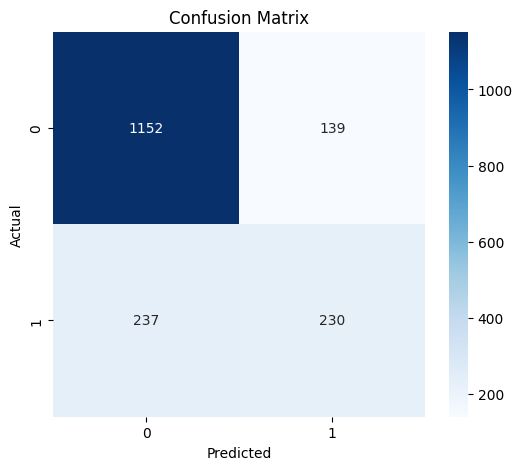

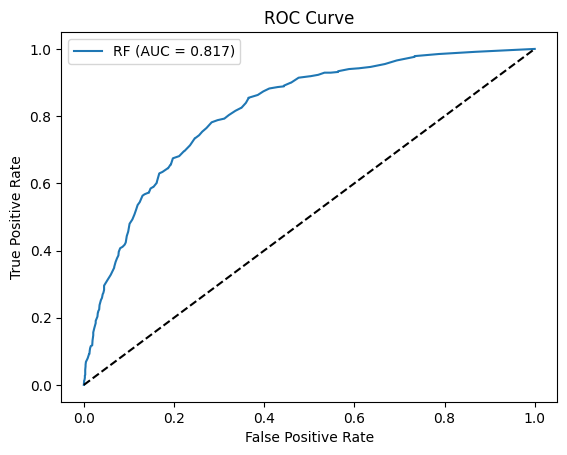

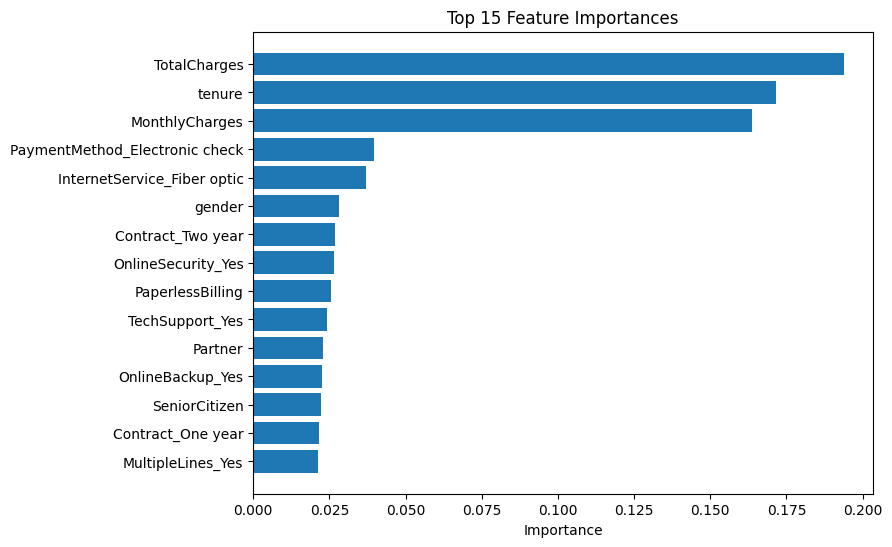

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Tuned RF Accuracy: 0.7946530147895335

Tuned RF ROC-AUC: 0.8358293373494975


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns


# Load and inspect the dataset
df = pd.read_csv('/Users/limengfeiyang/CMOR438-final-project/data/telco_churn_clean.csv')

print("First five rows:")
display(df.head())

print("\nData types and non-null counts:")
print(df.info())

print("\nClass distribution (Churn):")
print(df['Churn'].value_counts(normalize=True))


# Preprocessing

# Drop identifier column if present
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Encode categorical variables
# Identify object (string) columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")

# One-hot encode, dropping first level to avoid multicollinearity
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("\nShape after encoding:", df_encoded.shape)


# Define features and target
X = df_encoded.drop('Churn', axis=1).values
y = df_encoded['Churn'].values


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"\nTraining samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


# Baseline Random Forest model
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]


# Evaluation of baseline model
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'RF (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# Feature importances
importances = rf.feature_importances_
feat_names = df_encoded.drop('Churn', axis=1).columns

# Get top 15 features
indices = np.argsort(importances)[-15:]
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.show()


# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("\nBest parameters:", grid.best_params_)
best_rf = grid.best_estimator_

# Evaluate tuned model
y_pred_tuned = best_rf.predict(X_test)
y_proba_tuned = best_rf.predict_proba(X_test)[:, 1]
print("\nTuned RF Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nTuned RF ROC-AUC:", roc_auc_score(y_test, y_proba_tuned))

